In [9]:
from optimization_func import simulated_annealing
from helper import mse, mae, r2, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
t, P = get_predator_prey_data()
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats


In [4]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [5]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [6]:
def Convergence_data(rvs, cost, n_sim=100, gamma = 0.2):
    Dict = {}
    for rv in rvs:
        sim_data = []
        r2s = []
        for n in range(n_sim):
            state, _, _, costs = simulated_annealing(rv, t, P, cost=cost, cooling_schedule="quadratic", T_start=200, T_steps=2000, write_costs = True, gamma = gamma)
            sim_data.append(costs)
            r2_value = int_cost_lotka_volterra(state, P, t, cost=r2)
            r2s.append(r2_value)
        Dict[str(rv)] = (sim_data, r2s)
    
    return Dict           
    
    

In [43]:

old = [
    [2.2988017 , 3.20607768, 3.5464969 , 0.52816432], # bad guess (MSE ~ 387.6)
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
    [3.80478798, 3.48457439, 0.50790732, 2.3242911], # average guess (MSE ~ 69.8)
    [2.38611097, 0.52055825, 2.85603367, 1.23508492], # average guess (MSE ~ 44.7)
    [3.92634855, 2.93015479, 0.82022043, 2.67153322] # average guess (MSE ~ 28.6)
]

xs = [[0.66593614, 2.94213991, 8.129154  , 4.88824876], #10
    [3.13320535, 0.61170786, 1.20556467, 8.54715741], #77
    [1.59035578, 3.964897  , 8.93986609, 2.72514184], #9
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
    [3.92634855, 2.93015479, 0.82022043, 2.67153322], # average guess (MSE ~ 28.6)
]

xs_chosen = [[0.66593614, 2.94213991, 8.129154  , 4.88824876], #10
    [1.59035578, 3.964897  , 8.93986609, 2.72514184], #9
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
  ]



In [10]:
%%time
np.random.seed(567567)
if False: 
    shelf = shelve.open("Arrays/MSE_vs_MAE")
    Test_mse = Convergence_data(rvs=xs, cost=mse)
    shelf["Test_mse"] = Test_mse
    Test_mae = Convergence_data(rvs=xs, cost=mae)
    shelf["Test_mae"] = Test_mae
    shelf.close() 

Wall time: 0 ns


In [13]:
shelf = shelve.open("Arrays/MSE_vs_MAE")
Test_mse = shelf["Test_mse"] 
Test_mae = shelf["Test_mae"] 
shelf.close() 

In [98]:
def Convergence_plotter(rvs, Test_mse, Test_mae, T_steps=2000):
    iterations = range(1,T_steps + 2)
    Cost = ["MSE", "MAE"]
    i = 0
    for data in  [Test_mse, Test_mae]:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        j = 0
        for rv in rvs:
            results = data[str(rv)][0]
            mean = np.mean(results, axis = 0)
            r2_mean = np.mean(data[str(rv)][1], axis = 0)
            a = [sp_confidence_interval(samples) for samples in np.array(results).T]
            plt.hlines(y=mean[-1]*1.1, xmin=0, xmax=T_steps, linestyles='--', color = colors[j], linewidth = 1) 
            plt.plot(iterations, mean, colors[j], linewidth = 1, label = "$R^2$ final solution " + str(round(r2_mean, 2)))
            
            #plt.errorbar(iterations, mean, yerr=a, capsize = 1, elinewidth=0.5, markeredgewidth=1)
            plt.fill_between(iterations, mean - a, mean + a, alpha = 0.2, color = colors[j])
            j += 1
            
        plt.grid(alpha=0.3)
        plt.ylabel(Cost[i])
        i +=1
        plt.xlabel("Point in Markov Chain ($k_i$)")
        #plt.yscale("log")
        plt.legend()
        plt.show()  


C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


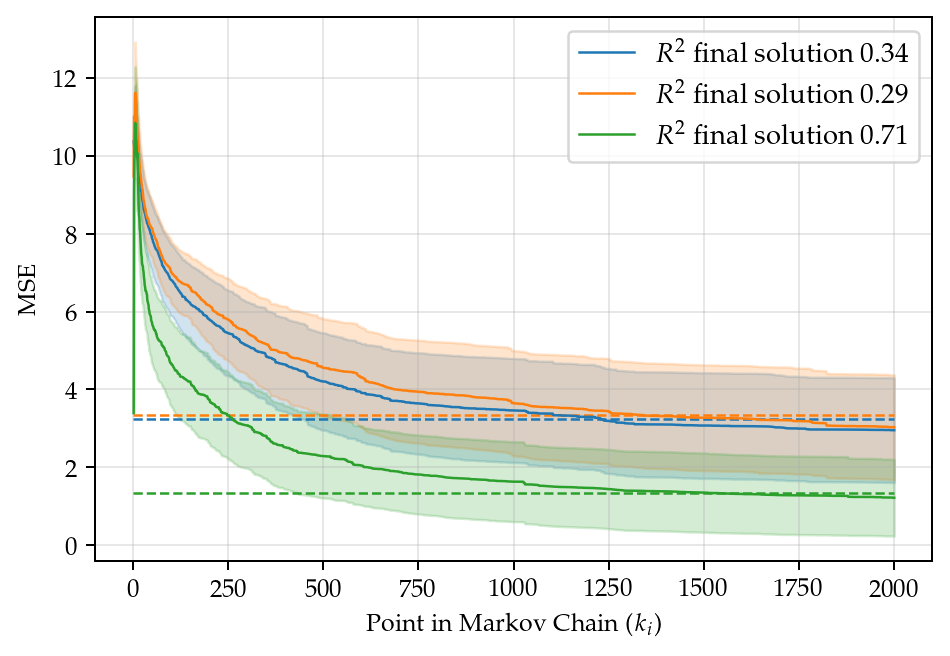

C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


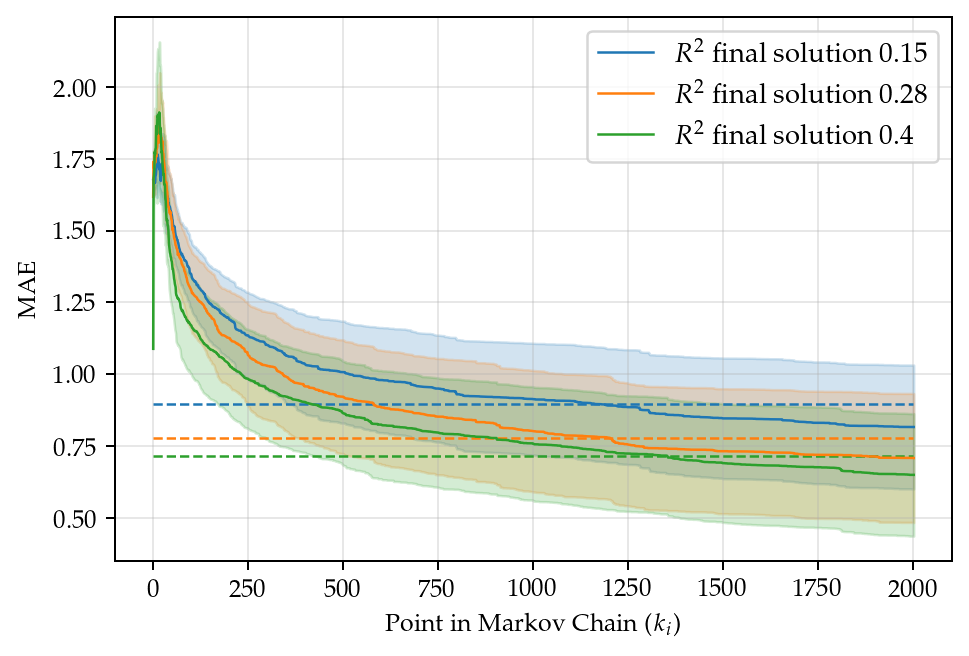

In [99]:
Convergence_plotter(xs_chosen, Test_mse, Test_mae, T_steps=2000)